In [1]:
import pandas as pd 
llama_70B = pd.read_csv('essay_prompts_llama_70B.csv', sep=';')

In [2]:
llama_70B.columns

Index(['Unnamed: 0', 'essay_prompt_raw', ' essay_type', 'source',
       'prompt_with_errors', 'essay_base', 'essay_from_error_prompt',
       'essay_prompt_AAE', 'essay_from_AAE_prompt', 'prompt_with_errors_v2',
       'essay_from_prompt_with_errors_v2'],
      dtype='object')

In [9]:
def remove_instruction(text):
    start_token = '[INST]'
    end_token = '[/INST]'
    start_index = text.find(start_token)
    end_index = text.find(end_token)

    if start_index != -1 and end_index != -1:
        return text[:start_index] + text[end_index + len(end_token):]
    else:
        return text

# Apply the function to the DataFrame
llama_70B['essay_from_prompt_with_errors_v2'] = llama_70B['essay_from_prompt_with_errors_v2'].apply(remove_instruction)

In [10]:
llama_70B['essay_from_prompt_with_errors_v2']

0      <s> \n\n     I disagree wi th statement "Peopl...
1      <s> \n\n     I disagree wit the statement dat ...
2      <s> \n\n     I disagree with the statement tha...
3      <s> \n\n     I disagree with the statement tha...
4      <s> \n\n     I disagree wit the statement dat ...
                             ...                        
175    <s> \n\n     Spesifically, the topic question ...
176    <s> \n\n     Compare and contrast the two choi...
177    <s> \n\n     and interesting stories. These re...
178    <s> \n\n     There are various ways of learnin...
179    <s> \n\n     Sure, I can help you with that.\n...
Name: essay_from_prompt_with_errors_v2, Length: 180, dtype: object

In [15]:
import textstat
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.probability import FreqDist
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer
import language_tool_python 
import statistics

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('stopwords')
nltk.download('vader_lexicon')

def analyze_essay(essay):
    """
    Analyze various aspects of an essay for linguistic sophistication.

    :param essay: A string containing the essay text.
    :return: A dictionary with various metrics and an overall quality score.
    """
    
    #lt = language_tool_python.LanguageToolPublicAPI('en-US')
    #sia = SentimentIntensityAnalyzer()

    # Readability and complexity metrics
    flesch_reading_ease = textstat.flesch_reading_ease(essay)
    smog_index = textstat.smog_index(essay)
    flesch_kincaid_grade = textstat.flesch_kincaid_grade(essay)

    # Tokenize essay into words and sentences
    words = word_tokenize(essay)
    sentences = sent_tokenize(essay)
    unique_words = len(set(words))

    # Lexical diversity
    lexical_diversity = len(set(words)) / len(words) if words else 0

    # Sentence length variability
    sentence_lengths = [len(word_tokenize(sentence)) for sentence in sentences]
    sentence_length_variability = statistics.stdev(sentence_lengths) if len(sentence_lengths) > 1 else 0

    # Grammatical mistakes
    #matches = lt.check(essay)
    #grammar_errors = len(matches) 
    grammar_errors = 0

    # Organization
    # Placeholder: Checks for transition words as a proxy for organization
    transition_words = ['however', 'furthermore', 'moreover', 'thus', 'therefore', 'then', 'finally']
    organization_score = sum(1 for word in words if word.lower() in transition_words) / 5  # assuming 5 as a basic count for good organization

    # assuming 5 sentences as a basic developed paragraph
    development_score = len(sentences) / 5  

    # Complexity of sentence structures (using POS tagging)
    pos_tags = [pos for word, pos in nltk.pos_tag(words)]
    complex_structures = pos_tags.count('JJ') + pos_tags.count('NNP') + pos_tags.count('VBD')

    # Calculate overall quality score (example formula, can be customized)
    overall_quality = (
        (flesch_reading_ease + 100 - smog_index + 100 - flesch_kincaid_grade) +
        (lexical_diversity * 100 + unique_words * 0.5) - 
        (grammar_errors + sentence_length_variability - complex_structures)
    ) / 8
    return   {
        "flesch_reading_ease": flesch_reading_ease,
        "smog_index": smog_index,
        "development_score": development_score,
        "organization_score": organization_score,
        "flesch_kincaid_grade": flesch_kincaid_grade,
        "unique_words": unique_words,
        "lexical_diversity": lexical_diversity,
        "sentence_length_variability": sentence_length_variability,
        "grammar_errors": grammar_errors,
        "complex_structures": complex_structures,
        "overall_quality": overall_quality
    }
 #overall_quality

# Load essays
#essay1 = data.iloc[7, 5]
#essay2 = data.iloc[7, 6]

#linguistic sophistication
#results1 = analyze_essay(essay1)
#results2 = analyze_essay(essay2)
#print(results1)
#print(results2)


[nltk_data] Downloading package punkt to /Users/nils/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/nils/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /Users/nils/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/nils/nltk_data...


In [16]:
llama_70B['metrics_essay_base'] = llama_70B['essay_base'].apply(analyze_essay)
llama_70B['metrics_essay_errors'] = llama_70B['essay_from_error_prompt'].apply(analyze_essay)
llama_70B['metrics_essay_AAE'] = llama_70B['essay_from_AAE_prompt'].apply(analyze_essay)
llama_70B['metrics_essay_errors_v2'] = llama_70B['essay_from_prompt_with_errors_v2'].apply(analyze_essay)


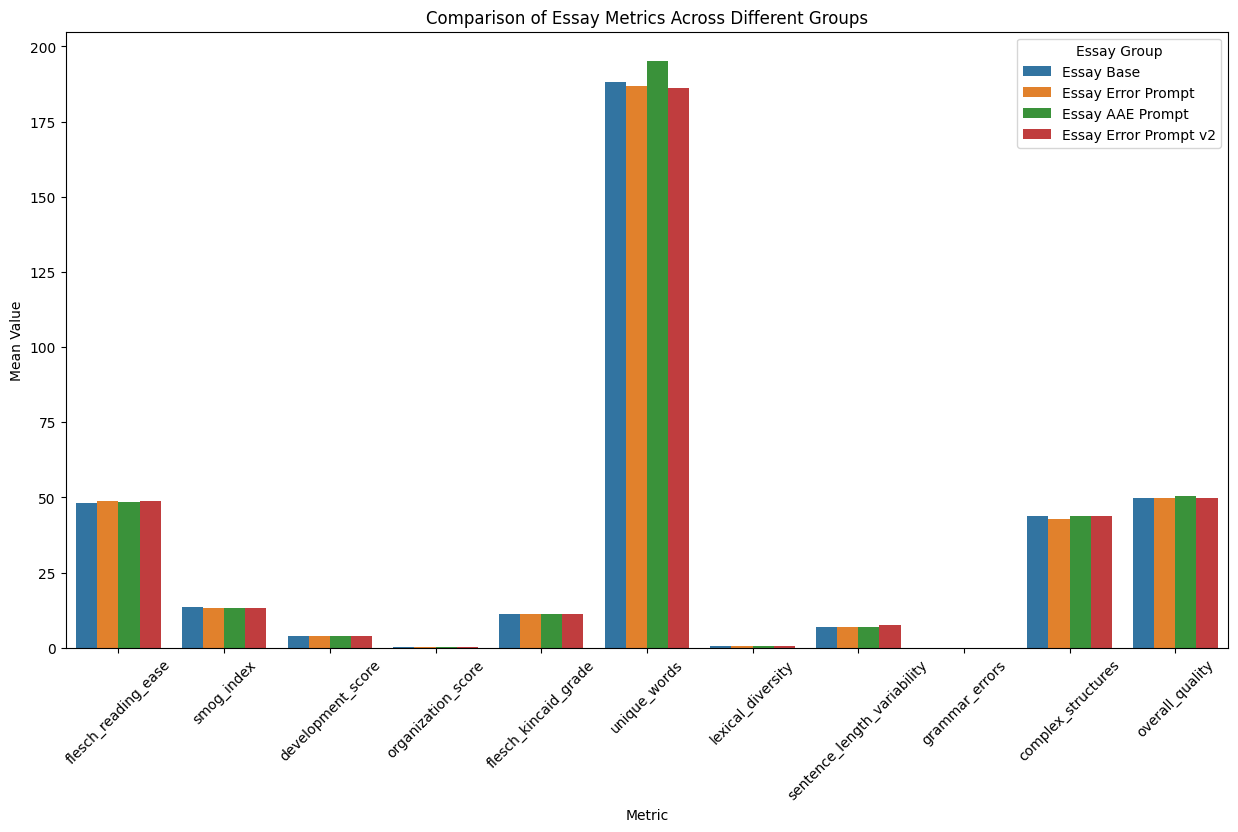

In [17]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Convert dictionaries to DataFrame
df_essay_base = pd.DataFrame(list(llama_70B['metrics_essay_base']))
df_essay_error_prompt = pd.DataFrame(list(llama_70B['metrics_essay_errors']))
df_essay_aae_prompt = pd.DataFrame(list(llama_70B['metrics_essay_AAE']))
df_essay_error_prompt_v2 = pd.DataFrame(list(llama_70B['metrics_essay_errors_v2']))



# Calculate means
means_essay_base = df_essay_base.mean()
means_essay_error_prompt = df_essay_error_prompt.mean()
means_essay_aae_prompt = df_essay_aae_prompt.mean()
means_essay_error_prompt_v2 = df_essay_error_prompt_v2.mean()



# Prepare data for visualization
mean_data = pd.DataFrame({
    'Metric': means_essay_base.index,
    'Essay Base': means_essay_base.values,
    'Essay Error Prompt': means_essay_error_prompt.values,
    'Essay AAE Prompt': means_essay_aae_prompt.values,
    'Essay Error Prompt v2': means_essay_error_prompt_v2
})

# Visualization
plt.figure(figsize=(15, 8))
sns.barplot(x='Metric', y='value', hue='variable', data=pd.melt(mean_data, ['Metric']))
plt.xticks(rotation=45)
plt.title('Comparison of Essay Metrics Across Different Groups')
plt.ylabel('Mean Value')
plt.xlabel('Metric')
plt.legend(title='Essay Group')
plt.show()

In [ ]:
llama_70B.to_csv('essay_prompts_llama_70B.csv', sep=';')